ДЗ
1) Попытаться ответить на вопросы/выдвинуть гипотезы

* 3 товара с акцией (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)

Увеличить вес акционных товаров в user_item матрице, после обучения, при рекомендациях, в отранжированом списке, сперва рекомендовать топ-3 товара из акционных, и топ-2 товара из неакционных. Вес акционных товаров, можно повышать пропорционально скидке

* 1 новый товар (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?)

можно попробовать обучить модель второго уровня, на основе фичей товаров (задача поиска похожих), и искать новые товары близкие к тем которые пользователь уже купил

* 1 товар для роста среднего чека (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Если рещать это с помощью фильтрации аутпута ALS, можно попробовать расчитать средний или медианный чек, и рекомендовать товар, превышающий заданную стоимость, при этом товар не должен быть слишком дорогим, поэтому мы можем также задать границу максимальной стоимости, например по самому дорогому товару, который покупал пользователь.

4) Поэкспериментировать с ALS (grid-search)

In [1]:
DRIVE_PATH = ''

In [2]:
# conda install -c conda-forge implicit
# !pip install hyperopt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
import os, sys

# Функции из 1-ого вебинара
module_path = DRIVE_PATH
if module_path not in sys.path:
    sys.path.append(module_path)
from metrics import precision_at_k, recall_at_k

pd.options.mode.chained_assignment = None

In [4]:
data = pd.read_csv(os.path.join(DRIVE_PATH, 'retail_train.csv'))

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

item_features = pd.read_csv(os.path.join(DRIVE_PATH, 'product.csv'))
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.82


In [5]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
    popularity['share_unique_users'] = popularity['user_id'] / data['user_id'].nunique()

    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    week_of_last_purchaices = data_train.groupby('item_id')['week_no'].max().reset_index()
    bought_year_ago = week_of_last_purchaices[week_of_last_purchaices['week_no'] < (data_train['week_no'].max() - 52)].item_id.tolist()
    data = data[~data['item_id'].isin(bought_year_ago)]

    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    data = data[data['price'] > 1]
    # Уберем слишком дорогие товары
    data = data[data['price'] < 60]
    # ...
    return data
    
def postfilter_items(user_id, recommednations):
    pass

#### Подготовка данных для ALS

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
top_n = 5000
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_items = popularity.sort_values('n_sold', ascending=False).head(top_n).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_items), 'item_id'] = 999999
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 
user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Обучение модели

In [8]:
%%time

learning_matrix = bm25_weight(user_item_matrix.T).T

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(learning_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 4.86 s


In [9]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_item_matrix.loc[68, 397896]

1.0

In [11]:
df = pd.DataFrame.sparse.from_spmatrix(learning_matrix)
df.sparse.to_dense()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,5.673249,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2495,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.580301,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2496,24.516352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2497,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


#### Оценка качества

In [12]:
class Recomender:
    def __init__(self, model, user_item_matrix):
        self.model = model
        self.sparse_user_item = csr_matrix(user_item_matrix).tocsr()
        
        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values
        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        self.id_to_itemid = dict(zip(matrix_itemids, itemids))
        self.userid_to_id = dict(zip(userids, matrix_userids))

    def get_recommendations(self, user, N=5):
        res = [self.id_to_itemid[rec[0]] for rec in 
               self.model.recommend(userid=self.userid_to_id[user], 
                                    user_items=self.sparse_user_item,
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
        return res

In [13]:
%%time

recomender = Recomender(model, user_item_matrix)
result['predicted'] = result['user_id'].apply(lambda x: recomender.get_recommendations(x, N=5))
result.apply(lambda row: precision_at_k(row['predicted'], row['actual']), axis=1).mean()

Wall time: 47.5 s


0.19216454456414994

* regularization, iterations
* factors
* Вес (элемент в матрице user-item)

In [14]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from hyperopt.base import Trials
from functools import partial
import seaborn as sns

In [15]:
def objective(params, user_item_matrix, test_data):
    model = AlternatingLeastSquares(calculate_training_loss=True, num_threads=4)
    for param, val in params.items():
        setattr(model, param, val)
    
    learning_matrix = bm25_weight(user_item_matrix.T).T
    model.fit(csr_matrix(learning_matrix).T.tocsr(), show_progress=False)
    
    recomender = Recomender(model, user_item_matrix)
    res = test_data.copy(deep=True)
    #print(res)
    res['predicted'] = res['user_id'].apply(lambda x: recomender.get_recommendations(x, N=5))
    prec = res.apply(lambda row: precision_at_k(row['predicted'], row['actual']), axis=1).mean()

    return   {'loss': -prec, 'params': params, 'status': STATUS_OK}

In [16]:
space = {
    'regularization' : hp.uniform("regularization", 0.001, 0.01),
    'factors' : hp.choice('factors', np.arange(50, 150, dtype=int)),
    'iterations' : hp.choice('iterations', np.arange(15, 20, dtype=int))
}


result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

trials=Trials()
best = fmin( 
            fn=partial(objective, user_item_matrix=user_item_matrix, test_data=result),
            space=space, 
            algo=tpe.suggest, 
            max_evals=10,
            trials=trials,)

100%|██████████████████████████████████████████████| 10/10 [07:59<00:00, 47.97s/trial, best loss: -0.19647404505386581]


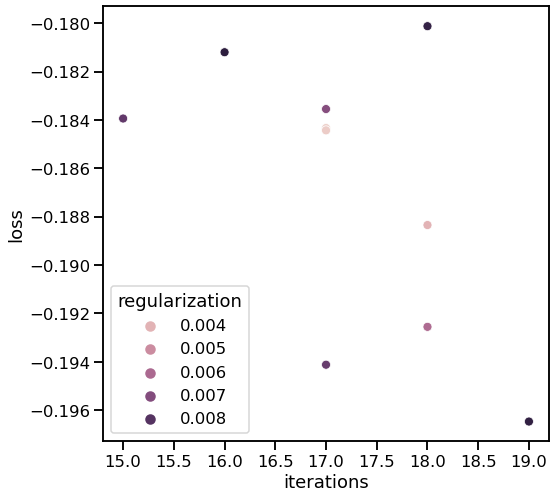

In [17]:
def df_results(hp_results):
    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=False, inplace=True)
    return results

results = df_results(trials.results)
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='iterations', y='loss', hue='regularization', 
                                                   data=results);

Лучшие параметры

In [18]:
sorted([res for res in trials.results], key=lambda x: x['loss'])[0]

{'loss': -0.19647404505386581,
 'params': {'factors': 131,
  'iterations': 19,
  'regularization': 0.00879502272155765},
 'status': 'ok'}